***IMPORT DES DONNEES DE TRAFIC, BRUIT, METEO ET SONDAGE***

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append(r'C:\Users\martin.schoreisz\git\otv\otv\Transfert_Donnees')
sys.path.append(r'C:\Users\\martin.schoreisz\git\Outils\Outils\Martin_Perso')
sys.path.append(r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\donnees_produites\Python\src\Carac_situ_acoustiq')
sys.path.append(r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\donnees_produites\Python\src')

import os, re
import pandas as pd
import numpy as np
import altair as alt
from math import pi, log, cos, sqrt
from IPython.display import Image
from Import_stockage_donnees.Import_export_bdd import FichierMesureBruitCsv, FichierCsvEnquete, ResultatsEnquete, FichiersMeteo
from Import_stockage_donnees.Params import (bdd, attributMesureTrafic, listFichiers6Min, fichierHoraireS43, dicoSiteLibCanal, dossierTrafic,
                                            fichierHoraireS44S45, dicoLibCanalVoie, dicoLibCanalSens, listNatureMesure)
import Connexion_Transfert as ct
from Bruit.Niveaux import niveau2Pression, pression2Niveau, moyenneQuadratiquePression
from statistics import mean
from Import_trafics import Comptage_Dira

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
# alt.data_transformers.disable_max_rows()
# alt.data_transformers.enable('json')

# DONNEES BRUIT

> ## Lecture des fichiers ods

In [36]:
# exemple de lecture 
test = FichierMesureBruitCsv(r'C:\Users\martin.schoreisz\Documents\temp\BruitRessenti\mesures\CSV\sono1_10RuePierreRonsard\sono1_02-04-2022.csv')
# test.dfNiveauSpectre.head(10)

In [ ]:
# transfert vers Bdd par dossier
dossierSrc = r'C:\Users\martin.schoreisz\Documents\temp\BruitRessenti\mesures\CSV\sono4_26RueFrancoisVillon'
transfertFichierMesure2Bdd(dossierSrc)

# DONNEES RESSENTI

## Import des données brutes  
Il s'agit de lire le fichier, de le nettoyer puis de le rendre plus compréhensible.  
Comme le fichier mélange des données fournies par les riverains directement par LimeSurvey et d'autre issus du transfert depuis des questionnaires papiers, il faut également s'assurer de la présence d'un identifiant unique par riverains, en créant des adresses mail factice pour les réoponses issues de questionaire papier.

In [87]:
ressenti = FichierCsvEnquete(r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\Enquete_LimeSurvey\resultats_LimeSurvey_Bruts\resultats_complets_enquete_avec_papier.csv')
# cf les attributs pour consulter les données si besoin

# DONNEES MÉTÉO
L'objectif est double : 
1. fournir des rose des vents selon une période de temps définie
1. fournir le statut de propagation acoustique (favorable / défavorable) selon l'angle et une période de temps définie

## Import des données brutes  
Les données sont réparties sur 2 fichiers dans le dossier suivant C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\mesures\station_meteo\datas  
On en profite pour jeter un oeil aux données fournie par les girouette

In [3]:
fichierMeteo = FichiersMeteo(r'C:\Users\martin.schoreisz\Box\Cerema\3E-Prod_Env_Risq\E6-Nuisances\E61-Acoustique\60-Etudes_Locales\2022-BruitRessentiBdxMet\4-Travaux_en_cours\mesures\station_meteo\datas',
                             ['Mesures_Ech24_21-03-2022_04-04-2022.csv', 'Mesures_Ech24_04-04-2022_19-04-2022.csv'])

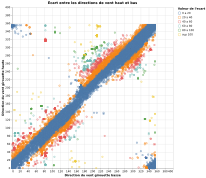

In [14]:
# preparation des données de comparaison des girouettes
dfDirVentComp = fichierMeteo.analyseDirVents(fichierMeteo.dfBrutes)
# si besoin : fichierMeteo.graphDiffDirVent(dfDirVentComp, fichier_de_sauvegarde)
# visu des résultats
Image('images/ecart_dirVent_HautBas.png', width=600, height=600)

**Dans tous les cas les données à conserver sont celles de la girouette haute. Cependant, on peut noter que les différences supérieures à 40° sont marginales**

# DONNÉES TRAFIC
Il y a de la donnée sur la Rocade, l'avenue dubedout et l'ex-RD936 
dans tous les cas, il est possible de sortir de la donnée 6 minutes

## Rocade
les fichiers sont :
- 6 minutes en débit / vitesses pour les sections courantes
- 6 minutes en debit pour les bretelles
- horaire pour le %PL sur section courante
Dans certains fichier il y a la section courante complete, plus les décomposition en voie je pense. ça se trouve dans les 'lib_Canal', en XXXX.00 pour la section courante dans un sens ou en XXXX.91 ou 93 ou 95 et XXXX.90 ou 92 ou 94. La relation avec la réalité est assuré par les fichiers horaires et les données OTV.<br>

Il faut également filtrer certaines données 6 minutes entre 02h00 et 03h00, sur les 3 compteurs, car aucunes données n'est remontée.<br>

In [125]:
# ouverture et filtre des données
df6Min = pd.concat([pd.read_excel(f) for f in listFichiers6Min])
df6MinFiltre = df6Min.loc[df6Min['Lib Canal'].isin(dicoLibCanalVoie.keys()) & (df6Min['nature de mesure'].isin(listNatureMesure))] .copy()

In [ ]:
# traitement des données 6 minutes
df6MinFiltre['date_heure'] = df6MinFiltre.apply(lambda x: pd.to_datetime(f'{x.jour} {x.sequence}') + pd.to_timedelta('1 s'), axis=1)
df6MinFiltre.loc[df6MinFiltre['nature de mesure'] == 'Débit', 'indicateur'] = 'TV'
df6MinFiltre.loc[df6MinFiltre['nature de mesure'] == 'Vitesse', 'indicateur'] = 'Vmoy'
df6MinFiltre['id_instru_site'] = df6MinFiltre['Lib Canal'].apply(lambda x: [k for k, v in dicoSiteLibCanal.items() if x in v][0])
df6MinFiltre['voie'] = df6MinFiltre['Lib Canal'].apply(lambda x: dicoLibCanalVoie[x])
df6MinFiltre['sens'] = df6MinFiltre['Lib Canal'].apply(lambda x: dicoLibCanalSens[x])
df6MinFiltre['periode_agreg'] = '6 min'
df6MinFiltre.rename(columns={'mesure': 'valeur'}, inplace = True)
df6MinFinal = df6MinFiltre.loc[df6MinFiltre.valeur.notna()].drop([c for c in df6MinFiltre.columns if c not in attributMesureTrafic], axis=1)

In [46]:
# traiatements des données horaires
dira = Comptage_Dira('toto', dossierTrafic, 'tutu', 2022, 'compteur')
dfHoraireBrute = pd.concat([dira.miseEnFormeFichier(fichierHoraireS43, nbJoursValideMin=1, FlagHorsOTV=True, nbHeure0Max=24).assign(id_instru_site=7),
                            dira.miseEnFormeFichier(fichierHoraireS44S45, nbJoursValideMin=1, FlagHorsOTV=True, nbHeure0Max=24).assign(id_instru_site=8)])
dfHoraire = dfHoraireBrute.melt(
    id_vars=['jour', 'type_veh', 'id_dira', 'voie', 'id_instru_site'],
    value_vars=[c for c in dfHoraireBrute.columns if c[0] == 'h'],
    value_name='valeur', var_name='heure').rename(columns={'type_veh': 'indicateur', 'voie': 'voie_init'})
dfHoraire['date_heure'] = dfHoraire.apply(lambda x: pd.to_datetime(f"{x.jour.date()} {x.heure.split('_')[0].replace('h','').rjust(2, '0')}:00:00"), axis=1)
dfHoraire['sens'] = dfHoraire.voie_init.apply(lambda x: ' '.join(x.split(' ')[:2]).lower())
dfHoraire['voie'] = dfHoraire.voie_init.apply(lambda x: ' '.join(x.split(' ')[2:]).lower() if len(x.split(' ')) > 2 else 'section courante')
dfHoraire['periode_agreg'] = '1 h'
dfHoraireFinal = dfHoraire.drop([c for c in dfHoraire.columns if c not in attributMesureTrafic], axis=1)

S_MB333.M_0
S_MB333.M_1
S_MB333.M_2
S_MB333.M_3
S_MB333.M_4
S_MB333.M_5
S_MB333.M_6
S_MB333.M_7
S_MBG33.N_0
S_MBG33.N_1


In [54]:
# transfert en bdd
with ct.ConnexionBdd(bdd) as c:
    dfHoraireFinal.loc[(dfHoraireFinal.date_heure.dt.dayofyear == 86) & (dfHoraireFinal.voie == 'voie rapide') &
                   (((dfHoraireFinal.sens == 'sens exter') & (dfHoraireFinal.id_instru_site == 7))) & (dfHoraireFinal.date_heure.dt.hour == 2)].to_sql('trafic', c.sqlAlchemyConn, schema='mesures_physiques', if_exists='append', index=False)

IntegrityError: (psycopg2.errors.UniqueViolation) ERREUR:  la valeur d'une clé dupliquée rompt la contrainte unique « trafic_un »
DETAIL:  La clé « (date_heure, id_instru_site, indicateur, periode_agreg, voie, sens)=(2022-03-27 02:00:00, 7, VL, 1 h, voie rapide, sens exter) » existe déjà.

[SQL: INSERT INTO mesures_physiques.trafic (indicateur, id_instru_site, valeur, date_heure, sens, voie, periode_agreg) VALUES (%(indicateur)s, %(id_instru_site)s, %(valeur)s, %(date_heure)s, %(sens)s, %(voie)s, %(periode_agreg)s)]
[parameters: ({'indicateur': 'VL', 'id_instru_site': 7, 'valeur': 13, 'date_heure': datetime.datetime(2022, 3, 27, 2, 0), 'sens': 'sens exter', 'voie': 'voie rapide', 'periode_agreg': '1 h'}, {'indicateur': 'PL', 'id_instru_site': 7, 'valeur': 0, 'date_heure': datetime.datetime(2022, 3, 27, 2, 0), 'sens': 'sens exter', 'voie': 'voie rapide', 'periode_agreg': '1 h'})]
(Background on this error at: http://sqlalche.me/e/14/gkpj)

In [52]:
dfHoraireFinal.loc[(dfHoraireFinal.date_heure.dt.dayofyear == 86) & (dfHoraireFinal.voie == 'voie rapide') &
                   (((dfHoraireFinal.sens == 'sens exter') & (dfHoraireFinal.id_instru_site == 7))) & (dfHoraireFinal.date_heure.dt.hour == 2)].head(20)

,indicateur,id_instru_site,valeur,date_heure,sens,voie,periode_agreg
2980,VL,7,13,2022-03-27 02:00:00,sens exter,voie rapide,1 h
2981,PL,7,0,2022-03-27 02:00:00,sens exter,voie rapide,1 h


In [38]:
test = dira.miseEnFormeFeuille(pd.read_excel(os.path.join(dossierTrafic, fichierHoraireS43), sheet_name=None), 'S_MB333.M_7', FlagHorsOTV=True)[0]

In [43]:
test.loc[test.jour == '2022-03-27']

,jour,type_veh,h0_1,h1_2,h2_3,h3_4,h4_5,h5_6,h6_7,h7_8,h8_9,h9_10,h10_11,h11_12,h12_13,h13_14,h14_15,h15_16,h16_17,h17_18,h18_19,h19_20,h20_21,h21_22,h22_23,h23_24,id_dira,voie,id_comptag,fichier
57,2022-03-27,VL,891,559,363,363,215,245,315,490,735,1224,1956,2782,2851,2249,2418,2956,3319,3971,3984,3299,2473,1447,945,526,s43(sensexter),Sens Exter,s43(sensexter),S43_Mar-Avril_2022.xls
58,2022-03-27,PL,83,60,68,79,62,70,68,100,99,135,168,207,205,182,186,208,208,209,160,179,237,176,308,283,s43(sensexter),Sens Exter,s43(sensexter),S43_Mar-Avril_2022.xls
57,2022-03-27,VL,730,446,375,318,210,245,425,555,787,1271,2030,2757,2637,2139,2310,2610,2952,3776,3928,3134,2175,1417,964,596,s43(sensinter),Sens Inter,s43(sensinter),S43_Mar-Avril_2022.xls
58,2022-03-27,PL,104,150,62,104,64,76,76,87,91,129,139,165,146,122,162,153,144,146,158,142,132,108,140,144,s43(sensinter),Sens Inter,s43(sensinter),S43_Mar-Avril_2022.xls
57,2022-03-27,VL,500,351,254,245,143,151,226,300,451,676,896,1103,1127,935,987,1073,1144,1347,1399,1228,901,642,416,253,s43(sensextervoielente),Sens Exter Voie Lente,s43(sensextervoielente),S43_Mar-Avril_2022.xls
58,2022-03-27,PL,72,55,60,72,55,66,63,81,93,113,121,146,144,130,140,141,136,138,109,132,160,128,244,226,s43(sensextervoielente),Sens Exter Voie Lente,s43(sensextervoielente),S43_Mar-Avril_2022.xls
57,2022-03-27,VL,332,191,96,107,65,80,79,171,260,473,869,1245,1255,1030,1100,1371,1489,1682,1658,1426,1107,651,426,229,s43(sensextervoiemediane),Sens Exter Voie Médiane,s43(sensextervoiemediane),S43_Mar-Avril_2022.xls
58,2022-03-27,PL,11,4,8,7,6,4,4,15,6,16,44,46,45,44,40,53,52,54,37,40,57,40,64,55,s43(sensextervoiemediane),Sens Exter Voie Médiane,s43(sensextervoiemediane),S43_Mar-Avril_2022.xls
57,2022-03-27,VL,59,17,13,11,7,14,10,19,24,75,191,434,469,284,331,512,686,942,927,645,465,154,103,44,s43(sensextervoierapide),Sens Exter Voie Rapide,s43(sensextervoierapide),S43_Mar-Avril_2022.xls
58,2022-03-27,PL,0,1,0,0,1,0,1,4,0,6,3,15,16,8,6,14,20,17,14,7,20,8,0,2,s43(sensextervoierapide),Sens Exter Voie Rapide,s43(sensextervoierapide),S43_Mar-Avril_2022.xls


In [42]:
test = dira.miseEnFormeFichier(fichierHoraireS43, nbJoursValideMin=1, FlagHorsOTV=True, nbHeure0Max=24)

S_MB333.M_0
S_MB333.M_1
S_MB333.M_2
S_MB333.M_3
S_MB333.M_4
S_MB333.M_5
S_MB333.M_6
S_MB333.M_7
